# Fine-tuning a CLIP-like model on human actions

In this notebook, we will see how to train a CLIP-like model on a image classification task.  
Specifically, the task is a multi-class classification problem where each class represent a human action.

CLIP has strong zero-shot performances on image classification tasks, but we will see that by training the model on our specific problem we can obtain even better results.  
We will also see that dealing with a VL model allow us for some other interesting tricks like open-domain classification: by changing classes names we can still obtain decent performances.

Note that the Huggingface CLIPModel that we will use for zero-shot classification cannot be directly fine-tuned via the `Trainer` API.  
Specifically  fine-tuning CLIP requires to set up a large number of functions and play a bit with the data. If you are interested in fine-tuning the original CLIP model you can sse for example [this](https://huggingface.co/blog/fine-tune-clip-rsicd) blog post.

However, CLIP is a kind of Vision-Text Dual Encoder model, and Huggingface has us covered on this. 

In this notebook, we will see how to train a new `VisionTextDualEncoderModel` with the CLIP Vision encoder and a Language Model of our choice as the text encoder (e.g., RoBERTa), and then train this new hybrid model on our task. It will be less general than CLIP, but it will get the job done better than it on our problem.


### How and why should I apply this?

What is the point of fine-tuning strong zero-shot capable models?  
I will for sure lose some of its generalization capabilities!

Yes, its _very_ true, and if you need a general model, that's the way to go, BUT...  
A few use cases where this may be useful:
- I need to train a classifier/image retrieval model on a problem that has quite uncommon labels but not tons of training data
    - E.g., an image-emotion classifier, like what we did in [Leveraging CLIP for Image Emotion Recognition (Bondielli and Passaro, 2021)](https://ceur-ws.org/Vol-3015/paper172.pdf) 
    - Starting from a strong baseline, we can cope with the lack of data better
- I have a specific classification/retrieval task to solve, and CLIP is quite good on it. I just want to nerd out and see if I can improve the performances on _my_ problem
- I have a specific classification/retrieval task to solve, and I want it to be as open-domain as possible, so a CLIP-like model is the perfect fit
    - E.g, I need the model to assign similar probabilties to "dog" and "puppy", or to "listening to music" and "vibing to music"
    - Since I want good performances on that specific task, and I don't really care about generalization in this case, I may as well fine-tune it
    
### What can you learn from the notebook

The notebook shows how to:
1. Use an available Huggingface `Dataset`
    1. Define appropriate data transformation functions for images and texts to provide correct inputs to a CLIP model 
1. Apply and evaluate a CLIP model on a specific task in zero-shot setting using Huggingface Transformers
1. Fine-tune a CLIP-like model as a `VisionTextDualEncoder` model
    1. using the Huggingface `Trainer` API 
    1. on a Huggingface Dataset
1. Evaluate the fine-tuned model on the task (both the strict task and in a more open-domain setting)

### What's not in notebook

In this notebook, you will not find:
1. How to load your own data in the Huggingface Dataset format
1. A hand-crafted VisionTextDualEncoder training-evaluation-test loop
1. Specifically fine-tuning the original CLIP model


## Table of Contents
* [Requirements](#requirements)
* [The human-actions Dataset](#dataset)
* [Zero-shot CLIP](#zeroshot)
* [Training a CLIP-like model on new data](#finetune)
    * [From data to inputs](#data-transform)
        * [Data transformations and data collator](#transform-and-collate)
    * [Training with Trainer](#training)
    * [Evaluation after training](#evaluation)
* [Testing the model on open-domain classification](#opendomain)

## Requirements<a class="anchor" id="requirements"></a>

First, we need to install a few Python libraries to get the job done.  
Most of the notebook is based on Huggingface Transformers and Dataset, but we also need some PyTorch and Torchvision based code to work with images.  
We'll also use SciKit-Learn for evaluating the classification results.

To install the libraries, a simple `pip install` follwoed by the name of the required libraries will be sufficient if you're installing from CLI.

If you're installing from inside the notebook, I suggest to use `sys.executable` to call the correct python executable, like this (don't forget the ! character at the beginning of the line):

In [ ]:
import sys

!{sys.executable} -m pip install transformers datasets torch torchvision scikit-learn matplotlib

Then, we can import the required modules and specific classes for each.

Here we also set the PyTorch `device` to `"cuda"` if we have one or more GPUs available so we can use it for training and inference. If we have Cuda available, we will print the info on our GPUs.

Finally, we also set a random seed to get reproducible results.

In [1]:
from datasets import load_dataset
from IPython.display import Image 


from transformers import (
    VisionTextDualEncoderModel,
    VisionTextDualEncoderProcessor,
    AutoTokenizer,
    AutoImageProcessor,
    AutoModel,
    Trainer,
    TrainingArguments,
    CLIPModel,
    CLIPProcessor,
    set_seed
)

import torch
import torch.nn.functional as F
from torchvision.io import ImageReadMode, read_image
from torchvision.transforms import CenterCrop, ConvertImageDtype, Normalize, Resize
from torchvision.transforms.functional import InterpolationMode
import torchvision.transforms.functional as trans

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
set_seed(23)

/home/bondielli/virtual-environments/lecturesCL-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda

NVIDIA A100-PCIE-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## The human-action Dataset<a class="anchor" id="dataset"></a>

For our experiment we will use a dataset for human action recognition.

The dataset features 15 different classes of Human Activities.
The dataset contains about 12k+ labelled images including the test images.
Each image has only one human activity category.

A small caveat: since the dataset was originally part of a [Kaggle competition](https://dphi.tech/challenges/data-sprint-76-human-activity-recognition/233/data), the test set is unlabelled.  
We will have to make do with the training set, and split it into train and validation. 

First, we load the dataset [from Huggingface](https://huggingface.co/datasets/Bingsu/Human_Action_Recognition). The dataset is quite small (~300MB), so it can fit easily in the memory.

In [2]:
dataset = load_dataset(
            "Bingsu/Human_Action_Recognition",
            keep_in_memory=False
        )

Found cached dataset parquet (/home/bondielli/.cache/huggingface/datasets/Bingsu___parquet/Bingsu--Human_Action_Recognition-6a68f3a126d63702/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|█████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 640.45it/s]


The dataset is a `DatasetDict` object, with `train` and  `test` splits (that are actually `Dataset` objects)

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 12600
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 5400
    })
})

We see that the dataset has only a `image` and `labels` column. Let's take a look at what's inside the first data point in the training set.

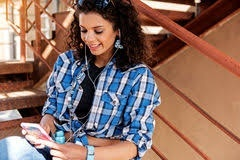

11

In [4]:
display(dataset['train'][0]['image'])
display(dataset['train'][0]['labels'])

Labels are numerical.
We have to convert the labels into their respective captions. Authors provided us with a caption-label mapping.

Based on the caption-label mapping, we can define a `labels_to_text` function that takes a batch of examples from the dataset and add a new `text_label` column to them.   
Then, we call the `map` function of the dataset to apply our function to the whole dataset.

In [5]:
caption_label_map = {
    'calling': 0,
    'clapping': 1,
    'cycling': 2,
    'dancing': 3,
    'drinking': 4,
    'eating': 5,
    'fighting': 6,
    'hugging': 7,
    'laughing': 8,
    'listening to music': 9,
    'running': 10,
    'sitting': 11,
    'sleeping': 12,
    'texting': 13,
    'using laptop': 14
}

label_caption_map = {v: k for k, v in caption_label_map.items()} # will be useful later


def labels_to_text(examples):
    # Takes a batch of samples, get the labels for the samples, convert them to texts with the dict. lookup and return the samples
    labels = list(examples['labels'])
    examples['text_label'] = [label_caption_map[l] for l in labels]
    return examples

# with .map we can apply the function to the whole dataset, either in batches or on single items
dataset = dataset.map(
    function=labels_to_text,
    batched=True,
    num_proc= 10,
    load_from_cache_file=False,
    desc="Converting labels to captions",
)

Now the dataset has an additional field.

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels', 'text_label'],
        num_rows: 12600
    })
    test: Dataset({
        features: ['image', 'labels', 'text_label'],
        num_rows: 5400
    })
})

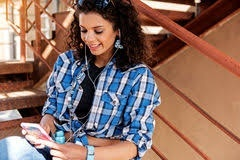

'sitting'

In [7]:
display(dataset['train'][0]['image'])
display(dataset['train'][0]['text_label'])

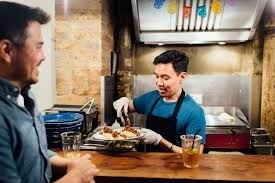

'calling'

In [8]:
display(dataset['test'][1]['image'])
display(dataset['test'][1]['text_label'])

As we said, the test set is unlabelled (i.e. all labels are set to class 0, `'calling'`).  

We will use only the training set, and split it into a train and a test split. We'll use 70% of the data for training and the rest for evaluation.

In [9]:
train_eval_dataset = dataset['train'].train_test_split(test_size=0.3, stratify_by_column = 'labels')
train_eval_dataset

Loading cached split indices for dataset at /home/bondielli/.cache/huggingface/datasets/Bingsu___parquet/Bingsu--Human_Action_Recognition-6a68f3a126d63702/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-89799292faad6f40.arrow and /home/bondielli/.cache/huggingface/datasets/Bingsu___parquet/Bingsu--Human_Action_Recognition-6a68f3a126d63702/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-b581ed2eef7d7cf9.arrow


DatasetDict({
    train: Dataset({
        features: ['image', 'labels', 'text_label'],
        num_rows: 8820
    })
    test: Dataset({
        features: ['image', 'labels', 'text_label'],
        num_rows: 3780
    })
})

## Zero-shot CLIP<a class="anchor" id="zeroshot"></a>

Now we load the base [CLIP model from Huggingface](https://huggingface.co/docs/transformers/model_doc/clip), and apply it to our task.

We know that CLIP is trained with a Contrastive Learning objective between images and captions. This means that the model projects both images and texts in the same latent space, where an image and its caption should be very close neighbours.

How can we leverage this to our advantage? Simple, we can extract the features of images and labels, and then compute the similarity score between the image and each caption and take the one with the highest cosine similarity. 

Let's go step by step. First we load the model and the processor (it converts images and text in a format that the model accepts, similar to a tokenizer for LMs).

In [10]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Since the model is trained on captions, it will probably be best if we generate a small caption from our label.  
We can use something very simple like `"a photho of people [label]"`.

In [11]:
labels = list(set(train_eval_dataset['test']['text_label']))
captions = [f"a photo of people {l}" for l in labels]

Now we get all the images in the test dataset

In [12]:
images = train_eval_dataset['test']['image']

Then we try to match images and captions.

We could separately model images and texts, and then model the similarity between the embeddings.  

However, the `CLIPModel` is designed to do this directly.  
The `CLIPModel` model, given as inputs some texts and images, returns a few different things as outputs:
1. Last hidden states of both vision and language models
1. A pooled output of both models
1. Embeddings for texts and images
1. **Logits for both texts and image**

We could model the similarity amomg embeddings for texts and images by ourselves.

But we can also exploit the logits: if we perform a softmax over the logits for images, we will get probabilities for each label!  
Obviously, if we do the opposite and start from the logits for texts, we will get probabilities for each image.

So, we first use the `CLIPProcessor` to "tokenize" our inputs, and then we feed the results directly into the model to get the outputs.

In [13]:
inputs = processor(text=captions, images=images, return_tensors="pt", padding=True)

outputs = model(**inputs)
outputs

CLIPOutput(loss=None, logits_per_image=tensor([[20.0293, 24.0269, 19.9236,  ..., 22.2463, 23.7105, 21.4768],
        [22.5325, 21.9242, 18.4103,  ..., 24.0808, 24.9385, 22.5083],
        [17.8616, 23.2029, 16.8955,  ..., 19.3671, 20.9283, 17.9465],
        ...,
        [18.2024, 18.8544, 22.9607,  ..., 22.7479, 24.3726, 21.7906],
        [20.4637, 20.3355, 22.4511,  ..., 23.2440, 25.5024, 19.6243],
        [21.3527, 20.6317, 19.5042,  ..., 25.0469, 22.9141, 21.6946]],
       grad_fn=<TBackward0>), logits_per_text=tensor([[20.0293, 22.5325, 17.8616,  ..., 18.2024, 20.4637, 21.3527],
        [24.0269, 21.9242, 23.2029,  ..., 18.8544, 20.3355, 20.6317],
        [19.9236, 18.4103, 16.8955,  ..., 22.9607, 22.4511, 19.5042],
        ...,
        [22.2463, 24.0808, 19.3671,  ..., 22.7479, 23.2440, 25.0469],
        [23.7105, 24.9385, 20.9283,  ..., 24.3726, 25.5024, 22.9141],
        [21.4768, 22.5083, 17.9465,  ..., 21.7906, 19.6243, 21.6946]],
       grad_fn=<MulBackward0>), text_embeds=ten

Then, we focus on the logits for each image. They are under `logits_per_image` in the outputs dictionary.

We apply a softmax to each logits tensor and get the label probabilities for each image.

In [14]:
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
probs.shape

torch.Size([3780, 15])

Let's take a look and see if the model is good.

We take an image from the dataset.  
To get the most likely label, we need to find the index of the higest probability for the image. We can use the `argmax` function for that. Then, we simply get the label with that index in our list of labels.

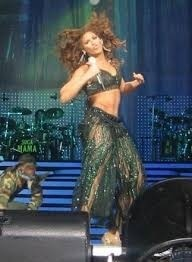

'dancing'

In [15]:
index = 124
image = train_eval_dataset['test']['image'][index]
label = labels[torch.argmax(probs[index])]

display(image)
display(label)

### Zero-shot evaluation

To conclude this section, we evalute the results on the test set with the zero-shot classifier.  
We get true and predicted labels from the dataset and the probabilites respectively (with the argmax trick) and the use scikit-learn to produce a nice looking classification report and confusion matrix (with matpolotlib in the background for visualization).

In [16]:
true_labels = train_eval_dataset['test']['labels']

predicted_labels = [caption_label_map[labels[torch.argmax(probs[index])]] for index in range(train_eval_dataset['test'].num_rows)]

print(classification_report(true_labels, predicted_labels, target_names = labels))

                    precision    recall  f1-score   support

           cycling       0.76      0.76      0.76       252
           dancing       0.74      0.82      0.78       252
listening to music       0.97      0.99      0.98       252
           calling       0.86      0.92      0.89       252
          clapping       0.91      0.85      0.88       252
          fighting       0.80      0.94      0.86       252
      using laptop       0.89      0.86      0.88       252
           hugging       0.90      0.70      0.79       252
           texting       0.56      0.88      0.69       252
          drinking       0.95      0.65      0.78       252
           sitting       0.96      0.85      0.90       252
           running       0.79      0.52      0.63       252
            eating       0.89      0.91      0.90       252
          laughing       0.79      0.72      0.76       252
          sleeping       0.74      0.90      0.81       252

          accuracy                    

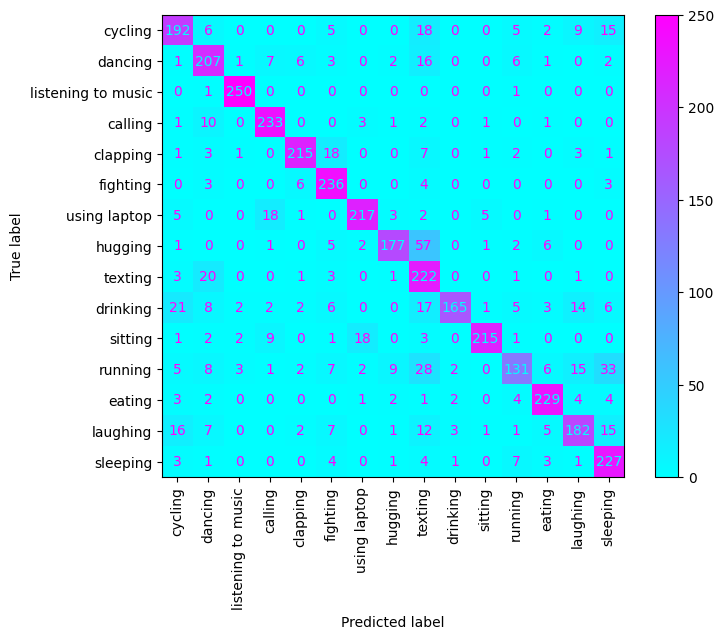

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
cm_disp = ConfusionMatrixDisplay.from_predictions(true_labels, 
                                                  predicted_labels, 
                                                  display_labels=labels, 
                                                  cmap = "cool", 
                                                  ax = ax,
                                                  xticks_rotation = "vertical")
plt.show()

## Training a CLIP-like model on new data<a class="anchor" id="finetune"></a>

Now we dive into how to fine-tune a CLIP-like model on our human-actions dataset.

We will create a new `VisionTextDualEncoderModel` initialized with the **CLIP vision encoder** and **RoBERTa-base** as the text encoder.  Note that you could follow the same procedure to initialize a completely different model, for example with the vision encoder from GIT and a BERT text encoder.  
The model will not be able to generalize like CLIP, but it will get the job done on our dataset.

The training will carried out via the `Trainer` API. It will take care of the training loop for us, and we will initialize it only with:
- Training arguments: the hyperparameters of the model (as a separate object)
- training set: the split of the HF dataset we will use for training
- validation set: the split of the HF dataset will use for validation
- a data collator: a function to collate images and text data into batches

We also need a few more functions to transform the data into the correct inputs for the model.

First, we initialize the model and its processor (comprising the text tokenizer and the image processor), and save the new pre-trained model. 

In [18]:
# initialize the VisionTextDualEncoderModel
model = VisionTextDualEncoderModel.from_vision_text_pretrained(
    "openai/clip-vit-base-patch32", "roberta-base"
)

# load tokenizer and image processors for the base models
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
image_processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

# initialize the processor for the new model
processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)

# define a directory to save the trained model
model_dir = "human-actions-clip-roberta" 

# save the model and processor
model.save_pretrained(model_dir)
processor.save_pretrained(model_dir)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.9.layer_norm2.bias', 'text_model.encoder.layers.0.self_attn.v_proj.bias', 'text_model.encoder.layers.4.self_attn.q_proj.bias', 'text_model.encoder.layers.9.self_attn.v_proj.weight', 'text_model.encoder.layers.10.self_attn.out_proj.weight', 'text_model.encoder.layers.3.self_attn.v_proj.bias', 'text_model.encoder.layers.6.self_attn.v_proj.weight', 'text_model.encoder.layers.8.self_attn.q_proj.bias', 'text_model.encoder.layers.10.self_attn.k_proj.bias', 'text_model.encoder.layers.1.self_attn.v_proj.bias', 'text_model.encoder.layers.4.self_attn.v_proj.weight', 'text_model.encoder.layers.3.self_attn.q_proj.weight', 'text_model.encoder.layers.9.self_attn.k_proj.bias', 'text_model.encoder.layers.3.mlp.fc2.weight', 'text_model.encoder.layers.9.mlp.fc1.bias', 'text_model.encoder.layers.10.self_attn.out_proj.bias', 'text_model.encoder.layers.9.self_att

Just to be sure, we can re-load the new model from disk.

In [19]:
model = AutoModel.from_pretrained(model_dir)
config = model.config

### From data to inputs<a class="anchor" id="data-transform"></a>

We need to prepare our data to be fed as input to the model.  

Our training examples will be images and captions (i.e., "a photo of a \[label\]").

First, we can generate the captions and store them as a field of the `Dataset`, so that we don't have to generate them later.

We define the `labels_to_caption` function and use `map`to apply it to all the elements in the dataset (in batches).

In [20]:
def labels_to_caption(examples):
    labels = list(examples['text_label'])
    examples['caption'] = [f"a photo of people {l}" for l in labels]
    return examples

train_eval_dataset = train_eval_dataset.map(
    function=labels_to_caption,
    batched=True,
    num_proc= 1,
    load_from_cache_file=False,
    desc="Converting labels to captions",
)

train_eval_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels', 'text_label', 'caption'],
        num_rows: 8820
    })
    test: Dataset({
        features: ['image', 'labels', 'text_label', 'caption'],
        num_rows: 3780
    })
})

We will also need to specify the image and caption column. we will use the two variables to select the relevant fields during data transformations.

In [21]:
image_column = 'image'
caption_column = 'caption'

#### Data transformations and data collator<a class="anchor" id="transform-and-collate"></a>

Now we get to one of the most important parts to ensure that everyting runs smoothly. 

The `Trainer` directly feeds on the `Dataset`via a **data collator**.  
However, we cannot directly give the model images and texts.  
We need to process them into `pixel_values`and `input_ids`+`attention_mask` respectively. This is exactly what the `tokenizer` does for LMs, and what the `processor` does for VLMs.

We can define a `tokenize_and_process` function that does both tokenization and image processing.
Then, instead of applying it directly with `.map()`, we can use the `.set_transform()` function on the `Dataset` objects. The function enable to apply a user-defined formatting to the dataset. In our case, the user defined formatting is the `tokenize_and_process` function: every time an item of the dataset, or a batch, is accessed, the `tokenize_and_process` function is called and `pixel_values`, `input_ids` and `attention_mask` are computed and returned.

This makes everyting faster and more memory efficient (especially with huge datasets).

First, let's define our user-defined transformation, `tokenize_and_process`. It takes a batch of data, computes the text inputs and image as PyTorch tensors, add them to the batch and returns it.

In [22]:
# we need a max sequence length for the tokenizer
max_seq_length = 24

# user-defined formatting. Examples represent a batch of data
def tokenize_and_process(examples):
    
    # get the captions from the batch
    captions = list(examples[caption_column])
    # tokenize the captions with the tokenizer
    text_inputs = tokenizer(captions, max_length=max_seq_length, truncation=True, padding = True, return_tensors = "pt")
    # add the input_ids and attention_mask fields to the dataset batch
    examples["input_ids"] = text_inputs.input_ids
    examples["attention_mask"] = text_inputs.attention_mask
    
    # we do the same with images, this time using the processon
    images = list(examples[image_column])
    image_inputs = image_processor(images=images, return_tensors="pt")
    examples["pixel_values"] = image_inputs.pixel_values
    
    return examples


We split the `DatasetDict` into a train and eval `Dataset` and use the set_transformation to apply our `tokenize_and_process` function on the fly when the dataset objects are called.

In [23]:
train_dataset = train_eval_dataset["train"]
eval_dataset = train_eval_dataset["test"]

train_dataset.set_transform(tokenize_and_process)
eval_dataset.set_transform(tokenize_and_process)

To put everything together, we also need the data collator function.  
This is the actual function that the `Trainer` calls to get batches of data.  
So we need it to first retrieve `pixel_values`, `input_ids` and `attention_mask` from the dataset. Note that when we call each example in the dataset, the `tokenize_and_process` function is applied on the fly.  
The inputs are returned togheter with `return_loss` set to `True` (since we are training the model).

In [24]:
def collate_fn(examples):
    # get the lists of tensors and stack them together
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    input_ids = torch.stack([example["input_ids"] for example in examples])
    attention_mask = torch.stack([example["attention_mask"] for example in examples])
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }

### Training with Trainer<a class="anchor" id="training"></a>

Now that we have everything in place, we can start training the model.  
We will need to initialize two key object: `TrainingArguments` and `Trainer`.

`TrainingArguments` defines all of the key aspects of training in terms of parameters and hyperparameters.  
We will use it to set the number of epochs, learning rate, the batch size, the weight decay and eventual warmup steps of the model, as well as the output directory for the fine-tuned model.  
We will just use some of its arguments. For the complete list of arguments, refer to [the documentation](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/trainer#transformers.TrainingArguments).

the `Trainer` object is an API for training models. It takes care of the whole training loop.  
A minimal `Trainer` includes:
- `model`: the model to be trained
- `args`: a `TrainingAgruments` object specifying hyperparameters for the training
- `train_dataset`: a `Dataset` object containing training data
- `eval_dataset` (optional): a `Dataset` object containing validation data
    - At each eval step, the model is fed with the validation dataset and performances are returned (but the model weights are not updated!)
- `data_collator` (optional): a collator function to create batches of data

We also want to freeze the parameters of the image and text models. We are going to train only the contrastive loss, otherwise the models (especially the text one) will incur in catastrophic forgetting, as it would be re-trained on as little as 15 sentences.

In [25]:
freeze_vision_model = True
freeze_text_model = True

def _freeze_params(module):
    for param in module.parameters():
        param.requires_grad = False

if freeze_vision_model:
    _freeze_params(model.vision_model)

if freeze_text_model:
    _freeze_params(model.text_model)

We define our `TrainingArguments` with 15 epochs, a learning rate of 5e-5, and a batch size of 32.

In [26]:
training_args = TrainingArguments(
    output_dir=model_dir, 
    num_train_epochs=15,
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    warmup_steps=0,
    weight_decay=0.1,
    remove_unused_columns=False,
    report_to="none"
    )

We then initialize the `Trainer`

In [27]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
)

And let huggingface do its magic by calling `trainer.train()`  
At the end of the training process the model, tokenizer and processor are saved to disk.

In [28]:
train_result = trainer.train()
trainer.save_model()
tokenizer.save_pretrained(model_dir)
image_processor.save_pretrained(model_dir)
trainer.save_state()

/home/bondielli/virtual-environments/lecturesCL-venv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,3.020413
2,3.228800,2.456733
3,3.228800,2.058693
4,2.683400,1.944826
5,2.683400,1.830355
6,2.445100,1.695999
7,2.445100,1.680590
8,2.287200,1.682561
9,2.287200,1.672675
10,2.184200,1.629022


With these parameters, our model starts to plateau at around epoch 11 and starts to overfit around epoch 15. This is visible by looking at training and validation losses. 

### Evaluation after training<a class="anchor" id="evaluation"></a>

Now we take a look at the performances of our newly trained model on the dataset. We will use the test part of our split to evaluate the model.

We will follow the same exact process as for the [zero-shot evaluation](#zeroshot), but this time with our new model `VisionTextDualEncoderModel` instead of of CLIP.

In [29]:
# load the model from disk

model_dir = "./human-actions-clip-roberta"

model = VisionTextDualEncoderModel.from_pretrained(model_dir)
processor = VisionTextDualEncoderProcessor.from_pretrained(model_dir)

We need to re-set the format of the dataset to its original state.

In [30]:
train_eval_dataset.reset_format()
train_eval_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels', 'text_label', 'caption'],
        num_rows: 8820
    })
    test: Dataset({
        features: ['image', 'labels', 'text_label', 'caption'],
        num_rows: 3780
    })
})

In [31]:
labels = list(set(train_eval_dataset['test']['text_label']))
captions = [f"a photo of people {l}" for l in labels]
images = train_eval_dataset['test']['image']

In [33]:
inputs = processor(text=captions, images=images, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
probs.shape

torch.Size([3780, 15])

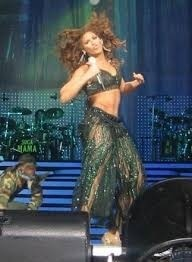

'dancing'

In [34]:
index = 124
image = train_eval_dataset['test']['image'][index]
label = labels[torch.argmax(probs[index])]

display(image)
display(label)

In [ ]:
true_labels = train_eval_dataset['test']['labels']

predicted_labels = [caption_label_map[labels[torch.argmax(probs[index])]] for index in range(train_eval_dataset['test'].num_rows)]

In [35]:
true_labels = train_eval_dataset['test']['labels']

predicted_labels = [caption_label_map[labels[torch.argmax(probs[index])]] for index in range(train_eval_dataset['test'].num_rows)]

print(classification_report(true_labels, predicted_labels, target_names = labels))

                    precision    recall  f1-score   support

           cycling       0.88      0.81      0.84       252
           dancing       0.88      0.79      0.83       252
listening to music       0.97      0.99      0.98       252
           calling       0.92      0.91      0.91       252
          clapping       0.96      0.94      0.95       252
          fighting       0.91      0.95      0.93       252
      using laptop       0.83      0.97      0.90       252
           hugging       0.81      0.95      0.87       252
           texting       0.80      0.86      0.83       252
          drinking       0.89      0.76      0.82       252
           sitting       0.96      0.85      0.90       252
           running       0.76      0.65      0.70       252
            eating       0.89      0.94      0.91       252
          laughing       0.81      0.84      0.82       252
          sleeping       0.86      0.88      0.87       252

          accuracy                    

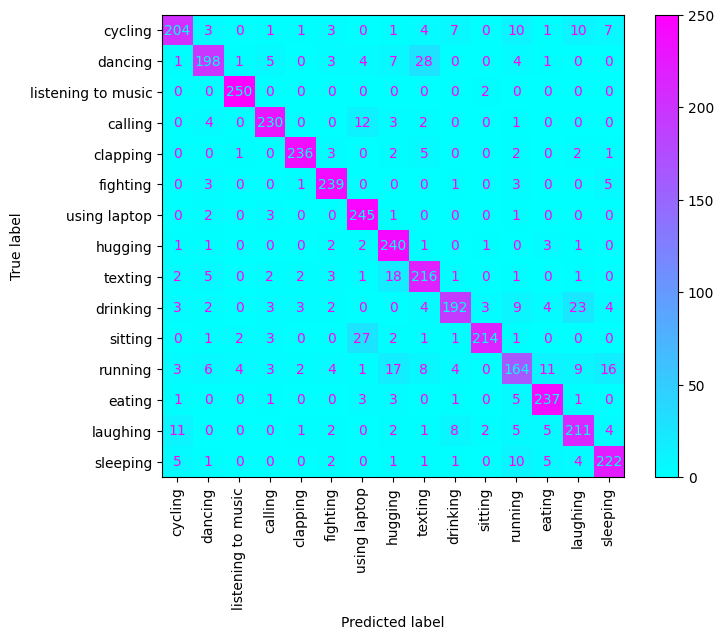

In [36]:
fig, ax = plt.subplots(figsize=(8,6))
cm_disp = ConfusionMatrixDisplay.from_predictions(true_labels, 
                                                  predicted_labels, 
                                                  display_labels=labels, 
                                                  cmap = "cool", 
                                                  ax = ax,
                                                  xticks_rotation = "vertical")
plt.show()

## Testing the model on open-domain classification<a class="anchor" id="opendomain"></a>

As a final test, we can try to look at how the model performs if we change the classes names slightly.  
We can change the text labels to synonims and evaluate the model in zero-shot setting.

In [37]:
dataset = load_dataset(
            "Bingsu/Human_Action_Recognition",
            keep_in_memory=False
        )

train_eval_dataset = dataset['train'].train_test_split(test_size=0.3, stratify_by_column = 'labels')
train_eval_dataset

Found cached dataset parquet (/home/bondielli/.cache/huggingface/datasets/Bingsu___parquet/Bingsu--Human_Action_Recognition-6a68f3a126d63702/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|█████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 524.26it/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 8820
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 3780
    })
})

Change the caption-label mapping

In [38]:
caption_label_map = {
    'on a phone call': 0, 
    'clapping hands': 1, 
    'riding a bike': 2,
    'on the dancefloor': 3,
    'having a drink': 4,
    'devouring': 5,
    'fighting each other': 6,
    'in a hug': 7,
    'smiling': 8,
    'vibing to music': 9,
    'sprinting': 10,
    'seated': 11,
    'napping': 12,
    'text messagging': 13,
    'at the PC': 14
}


label_caption_map = {v: k for k, v in caption_label_map.items()} # will be useful later

# with .map we can apply the function to the whole dataset, either in batches or on single items
train_eval_dataset = train_eval_dataset.map(
    function=labels_to_text,
    batched=True,
    num_proc= 10,
    load_from_cache_file=False,
    desc="Converting labels to captions",
)

And then we re-use some code from above to evaluate performances.

/home/bondielli/virtual-environments/lecturesCL-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bondielli/virtual-environments/lecturesCL-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bondielli/virtual-environments/lecturesCL-venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

                     precision    recall  f1-score   support

    on a phone call       0.50      0.81      0.62       252
          at the PC       0.78      0.87      0.83       252
    text messagging       0.93      0.94      0.94       252
  on the dancefloor       0.91      0.87      0.89       252
            napping       0.85      0.94      0.89       252
             seated       0.91      0.92      0.92       252
fighting each other       0.82      0.98      0.89       252
            smiling       0.84      0.93      0.88       252
      riding a bike       0.89      0.80      0.85       252
    vibing to music       0.87      0.69      0.77       252
          sprinting       0.91      0.89      0.90       252
          devouring       0.70      0.58      0.63       252
     having a drink       0.85      0.88      0.86       252
           in a hug       0.59      0.79      0.67       252
     clapping hands       0.00      0.00      0.00       252

           accuracy   

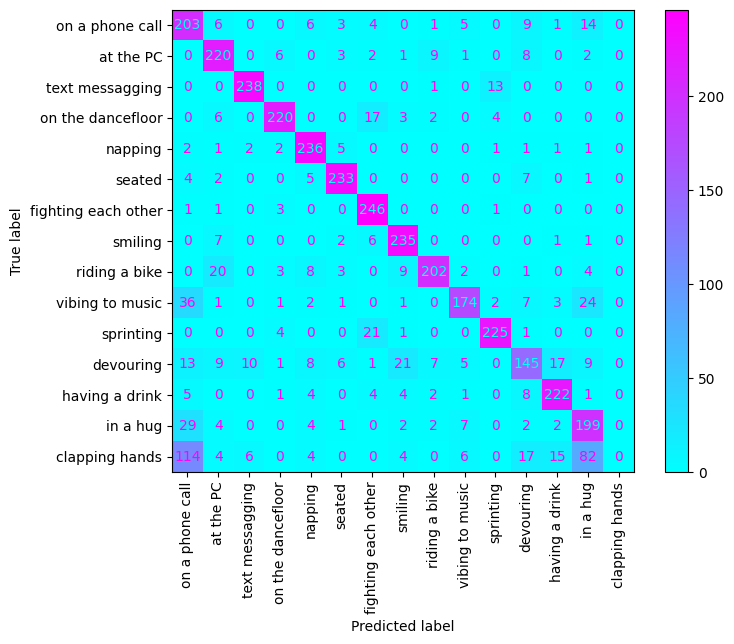

In [39]:
labels = list(set(train_eval_dataset['test']['text_label']))
captions = [f"a photo of people {l}" for l in labels]
images = train_eval_dataset['test']['image']

inputs = processor(text=captions, images=images, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

true_labels = train_eval_dataset['test']['labels']

predicted_labels = [caption_label_map[labels[torch.argmax(probs[index])]] for index in range(train_eval_dataset['test'].num_rows)]

print(classification_report(true_labels, predicted_labels, target_names = labels))

fig, ax = plt.subplots(figsize=(8,6))
cm_disp = ConfusionMatrixDisplay.from_predictions(true_labels, 
                                                  predicted_labels, 
                                                  display_labels=labels, 
                                                  cmap = "cool", 
                                                  ax = ax,
                                                  xticks_rotation = "vertical")
plt.show()

The model is working worse than on the original captions, obviously.  
It is also markedly worse than the zero-shot CLIP model (mostly due to a few classes being poorly recognized because very similar to each other).  
However, the model still achieve impressive performances considering it is trained on very little data to begin with (around 8000 samples).